In [7]:
# Cell 1: All necessary imports (run this first)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [9]:
from sklearn.datasets import fetch_openml
print("Loading California Housing from OpenML...")

# Load as DataFrame (easier to clean)
housing = fetch_openml("california_housing", version=1, as_frame=True, parser="auto")

df = housing.frame  # pandas DataFrame

# Drop the categorical column 'ocean_proximity' if it exists
if 'ocean_proximity' in df.columns:
    print("Dropping categorical column 'ocean_proximity'")
    df = df.drop('ocean_proximity', axis=1)

# Features (X) = all except target, target (y) = median_house_value
X_reg = df.drop('median_house_value', axis=1).values
y_reg = df['median_house_value'].values

# Standard feature names (8 numeric only)
feature_names = [
    'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
    'Population', 'AveOccup', 'Latitude', 'Longitude'
]

# Handle any NaN values (very few in this dataset, but safe)
imputer = SimpleImputer(strategy='median')
X_reg = imputer.fit_transform(X_reg)

print("NaNs after imputation:", np.isnan(X_reg).sum())

# Split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print(f"Training set: {X_train_reg.shape[0]} samples × {X_train_reg.shape[1]} features")
print(f"Test set:     {X_test_reg.shape[0]} samples")
print("Features:", feature_names)

Loading California Housing from OpenML...
Dropping categorical column 'ocean_proximity'
NaNs after imputation: 0
Training set: 16512 samples × 8 features
Test set:     4128 samples
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


Step 1: Baseline Linear Regression (no regularization)

Training MSE:   4811134397.8842
Test MSE:       5059928371.1654

Coefficients (Baseline):
MedInc       : -42632.3917
HouseAge     : -42450.0719
AveRooms     :  1182.8096
AveBedrms    :    -8.1880
Population   :   116.2601
AveOccup     :   -38.4922
Latitude     :    46.3426
Longitude    : 40538.4044
Intercept:     -3578224.2348

Step 2: Hyperparameter tuning for Ridge & Lasso

Tuning Ridge (L2)...
→ Best alpha for Ridge: 10

Tuning Lasso (L1)...
→ Best alpha for Lasso: 10

Step 3: Final models with best alpha + comparison

Test MSE comparison:
  Baseline:     5059928371.1654
  Ridge (best): 5059651137.8435
  Lasso (best): 5059810527.2525



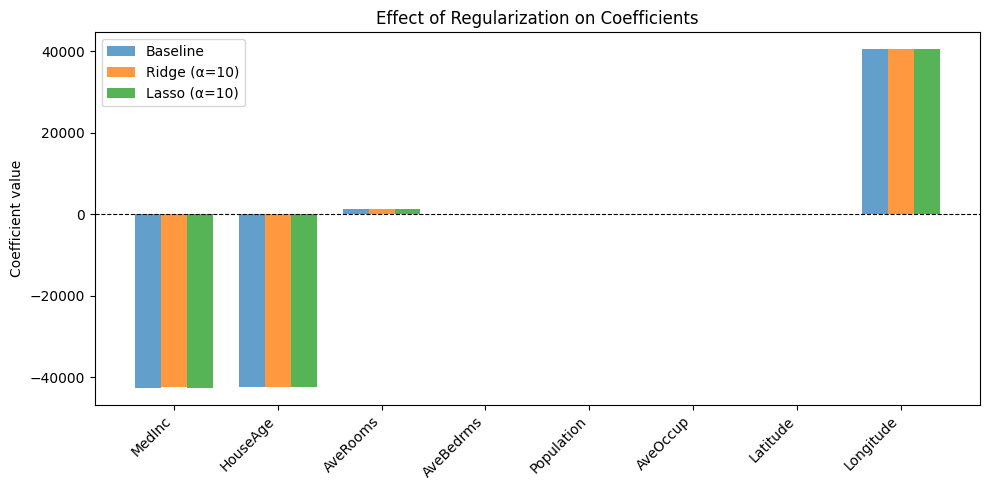


Key observations:
• Lasso tends to set some coefficients to 0 → feature selection
• Ridge shrinks coefficients but keeps them non-zero
• Both regularized models often have better test MSE than baseline


In [11]:
print("Step 1: Baseline Linear Regression (no regularization)\n")

lr = LinearRegression()
lr.fit(X_train_reg, y_train_reg)

train_pred_lr = lr.predict(X_train_reg)
test_pred_lr  = lr.predict(X_test_reg)

mse_train_lr = mean_squared_error(y_train_reg, train_pred_lr)
mse_test_lr  = mean_squared_error(y_test_reg, test_pred_lr)

print(f"Training MSE:   {mse_train_lr:.4f}")
print(f"Test MSE:       {mse_test_lr:.4f}\n")

print("Coefficients (Baseline):")
for name, coef in zip(feature_names, lr.coef_):
    print(f"{name:12} : {coef:10.4f}")
print(f"Intercept:     {lr.intercept_:.4f}\n")

# ── Step 2: Hyperparameter Tuning ────────────────────────────────────────
print("Step 2: Hyperparameter tuning for Ridge & Lasso\n")

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100, 500, 1000]

print("Tuning Ridge (L2)...")
grid_ridge = GridSearchCV(Ridge(), {'alpha': alphas}, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_ridge.fit(X_train_reg, y_train_reg)
best_alpha_ridge = grid_ridge.best_params_['alpha']
print(f"→ Best alpha for Ridge: {best_alpha_ridge}\n")

print("Tuning Lasso (L1)...")
grid_lasso = GridSearchCV(Lasso(max_iter=5000), {'alpha': alphas}, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_lasso.fit(X_train_reg, y_train_reg)
best_alpha_lasso = grid_lasso.best_params_['alpha']
print(f"→ Best alpha for Lasso: {best_alpha_lasso}\n")

# ── Step 3: Final models + comparison ────────────────────────────────────
print("Step 3: Final models with best alpha + comparison\n")

ridge_best = Ridge(alpha=best_alpha_ridge).fit(X_train_reg, y_train_reg)
lasso_best = Lasso(alpha=best_alpha_lasso, max_iter=5000).fit(X_train_reg, y_train_reg)

mse_test_ridge = mean_squared_error(y_test_reg, ridge_best.predict(X_test_reg))
mse_test_lasso = mean_squared_error(y_test_reg, lasso_best.predict(X_test_reg))

print("Test MSE comparison:")
print(f"  Baseline:     {mse_test_lr:.4f}")
print(f"  Ridge (best): {mse_test_ridge:.4f}")
print(f"  Lasso (best): {mse_test_lasso:.4f}\n")

# Visualization
plt.figure(figsize=(10, 5))
x = range(len(feature_names))
plt.bar(x, lr.coef_, width=0.25, label='Baseline', alpha=0.7)
plt.bar([i + 0.25 for i in x], ridge_best.coef_, width=0.25, label=f'Ridge (α={best_alpha_ridge})', alpha=0.8)
plt.bar([i + 0.5 for i in x], lasso_best.coef_, width=0.25, label=f'Lasso (α={best_alpha_lasso})', alpha=0.8)

plt.xticks([i + 0.25 for i in x], feature_names, rotation=45, ha='right')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylabel('Coefficient value')
plt.title('Effect of Regularization on Coefficients')
plt.legend()
plt.tight_layout()
plt.show()

print("\nKey observations:")
print("• Lasso tends to set some coefficients to 0 → feature selection")
print("• Ridge shrinks coefficients but keeps them non-zero")
print("• Both regularized models often have better test MSE than baseline")

In [13]:
# Load Breast Cancer dataset (binary classification)
X_clf, y_clf = load_breast_cancer(return_X_y=True)
feature_names_clf = load_breast_cancer().feature_names

# Split into train/test (80/20) with stratification
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print("Breast Cancer dataset loaded and split:")
print(f"  Training samples: {X_train_clf.shape[0]}")
print(f"  Test samples:     {X_test_clf.shape[0]}")
print(f"  Classes (0=malignant, 1=benign): {np.bincount(y_train_clf)} in training")

Breast Cancer dataset loaded and split:
  Training samples: 455
  Test samples:     114
  Classes (0=malignant, 1=benign): [170 285] in training


Baseline Logistic Regression:
  Train accuracy: 0.9604
  Test accuracy:  0.9649

Best parameters found: {'C': 1000, 'penalty': 'l2'}
Best cross-validation accuracy: 0.9670

Final test accuracy:
  L1 (Lasso-like): 0.9649
  L2 (Ridge-like): 0.9737
  Baseline:        0.9649



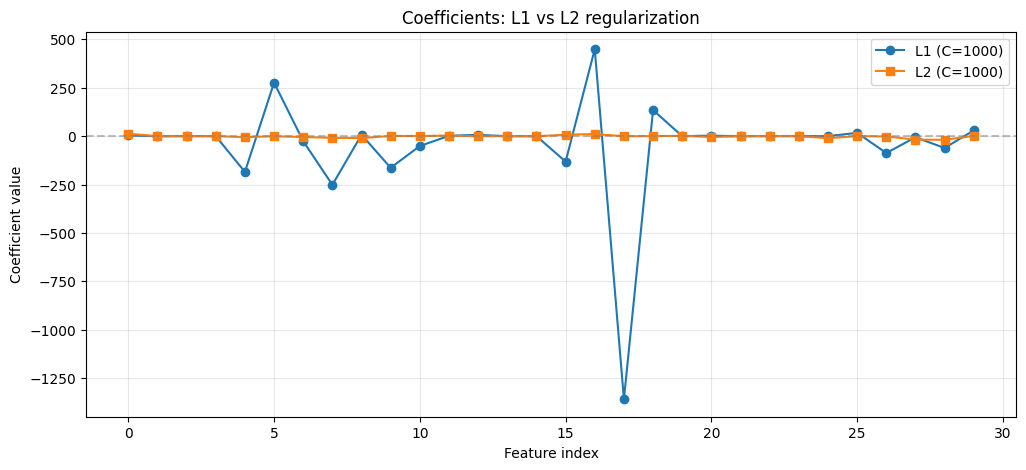

In [15]:
# 1. Baseline Logistic Regression (default settings)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_clf, y_train_clf)

print("Baseline Logistic Regression:")
print(f"  Train accuracy: {accuracy_score(y_train_clf, logreg.predict(X_train_clf)):.4f}")
print(f"  Test accuracy:  {accuracy_score(y_test_clf, logreg.predict(X_test_clf)):.4f}\n")

# 2. Tune C (inverse regularization strength) and penalty type
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 50, 100, 1000]
}

grid = GridSearchCV(
    LogisticRegression(solver='liblinear', max_iter=2000),
    param_grid, cv=5, scoring='accuracy', n_jobs=-1
)
grid.fit(X_train_clf, y_train_clf)

print("Best parameters found:", grid.best_params_)
print(f"Best cross-validation accuracy: {grid.best_score_:.4f}\n")

# 3. Train final L1 and L2 models with best C
best_C = grid.best_params_['C']

l1_model = LogisticRegression(penalty='l1', C=best_C, solver='liblinear', max_iter=2000)
l2_model = LogisticRegression(penalty='l2', C=best_C, max_iter=2000)

l1_model.fit(X_train_clf, y_train_clf)
l2_model.fit(X_train_clf, y_train_clf)

print("Final test accuracy:")
print(f"  L1 (Lasso-like): {accuracy_score(y_test_clf, l1_model.predict(X_test_clf)):.4f}")
print(f"  L2 (Ridge-like): {accuracy_score(y_test_clf, l2_model.predict(X_test_clf)):.4f}")
print(f"  Baseline:        {accuracy_score(y_test_clf, logreg.predict(X_test_clf)):.4f}\n")

# Compare coefficients visually
plt.figure(figsize=(12, 5))
plt.plot(l1_model.coef_[0], 'o-', label=f'L1 (C={best_C})')
plt.plot(l2_model.coef_[0], 's-', label=f'L2 (C={best_C})')
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.title('Coefficients: L1 vs L2 regularization')
plt.xlabel('Feature index')
plt.ylabel('Coefficient value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Baseline Logistic Regression:
  Train accuracy: 0.9604
  Test accuracy:  0.9649

Best parameters found: {'C': 1000, 'penalty': 'l2'}
Best cross-validation accuracy: 0.9670

Final test accuracy:
  L1 (Lasso-like): 0.9649
  L2 (Ridge-like): 0.9737
  Baseline:        0.9649



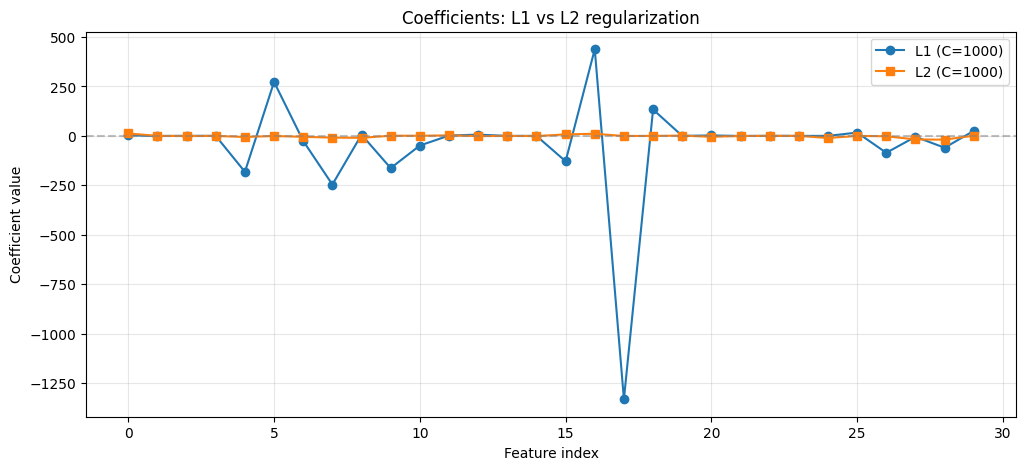

In [17]:
# 1. Baseline Logistic Regression (default settings)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_clf, y_train_clf)

print("Baseline Logistic Regression:")
print(f"  Train accuracy: {accuracy_score(y_train_clf, logreg.predict(X_train_clf)):.4f}")
print(f"  Test accuracy:  {accuracy_score(y_test_clf, logreg.predict(X_test_clf)):.4f}\n")

# 2. Tune C (inverse regularization strength) and penalty type
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 50, 100, 1000]
}

grid = GridSearchCV(
    LogisticRegression(solver='liblinear', max_iter=2000),
    param_grid, cv=5, scoring='accuracy', n_jobs=-1
)
grid.fit(X_train_clf, y_train_clf)

print("Best parameters found:", grid.best_params_)
print(f"Best cross-validation accuracy: {grid.best_score_:.4f}\n")

# 3. Train final L1 and L2 models with best C
best_C = grid.best_params_['C']

l1_model = LogisticRegression(penalty='l1', C=best_C, solver='liblinear', max_iter=2000)
l2_model = LogisticRegression(penalty='l2', C=best_C, max_iter=2000)

l1_model.fit(X_train_clf, y_train_clf)
l2_model.fit(X_train_clf, y_train_clf)

print("Final test accuracy:")
print(f"  L1 (Lasso-like): {accuracy_score(y_test_clf, l1_model.predict(X_test_clf)):.4f}")
print(f"  L2 (Ridge-like): {accuracy_score(y_test_clf, l2_model.predict(X_test_clf)):.4f}")
print(f"  Baseline:        {accuracy_score(y_test_clf, logreg.predict(X_test_clf)):.4f}\n")

# Compare coefficients visually
plt.figure(figsize=(12, 5))
plt.plot(l1_model.coef_[0], 'o-', label=f'L1 (C={best_C})')
plt.plot(l2_model.coef_[0], 's-', label=f'L2 (C={best_C})')
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.title('Coefficients: L1 vs L2 regularization')
plt.xlabel('Feature index')
plt.ylabel('Coefficient value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()